In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import scipy.stats as st
import os
import json

import optuna
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

c:\Users\sofia\anaconda3\envs\mi_entorno310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../scr')

from utils_clean import filtrar_ub_semanal, imputar_nulos_semanal, estacionarizar_arima, partir_train_test
from utils_data import downloadTable
from utils_model import buscar_hiperparametros_arima_sarima, buscar_hiperparametros_arima_semanal
from utils_metrics import errorMetrics

# Importar Data

In [3]:
queryPrices = """
SELECT * FROM `desarrollo-444913.globalPrices.prices`
"""
# Usar forceDownload=True para actualizar la tabla
df = downloadTable(queryPrices,"globalPricesTable",forceDownload=False)

Folder 'bigqueryDatabases' already exists.
Reading bigqueryDatabases\globalPricesTable.csv from local CSV.


In [4]:
df.head()

,date,price,priceId,priceName,currency,currencyId,priceType,source
0,2022-10-01,14.637188,4,Japan Frozen Atlantic TRIM-E,USD,0,EXPORT,CHILEAN EXPORTS
1,2023-03-01,12.265160,5,Japan Fresh Atlantic TRIM-A,USD,0,EXPORT,CHILEAN EXPORTS
2,2024-02-01,5.859417,1,Japan Frozen Coho HG,USD,0,EXPORT,CHILEAN EXPORTS
3,2012-11-08,6.724091,11,UB Atlantic TRIM-D 3-4 Lb FOB Miami,USD,0,EXPORTS,URNER BARRY
4,2007-12-26,7.495708,11,UB Atlantic TRIM-D 3-4 Lb FOB Miami,USD,0,EXPORTS,URNER BARRY


In [5]:
#  Crear la serie semanal
serie = filtrar_ub_semanal(df)

In [6]:
# 2) Imputar esos NaN con interpolación lineal
df_semanal, flags = imputar_nulos_semanal(
    serie, metodo="interpolate", devolver_flags=True
)

In [7]:
df_semanal

date
2007-01-08     9.038942
2007-01-15     9.038942
2007-01-22     9.204289
2007-01-29     9.369635
2007-02-05     9.479866
                ...    
2025-05-12    14.054452
2025-05-19    13.393066
2025-05-26    13.007258
2025-06-02    12.566334
2025-06-09    12.235641
Freq: W-MON, Name: price, Length: 962, dtype: float64

# Visualización

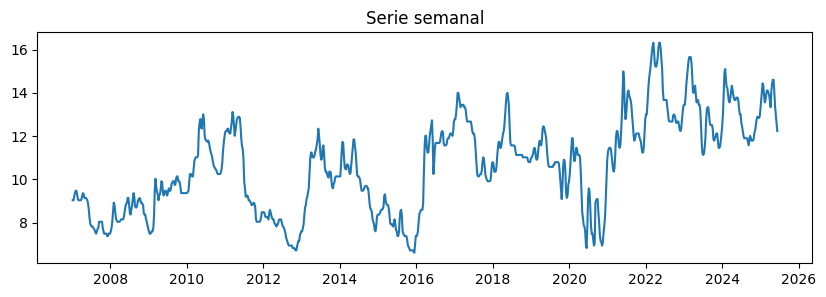

In [8]:
plt.figure(figsize=(10,3))
plt.plot(df_semanal)
plt.title("Serie semanal")
plt.show()

## Estacionariedad

In [9]:

serie = df_semanal.copy()

adf_res = adfuller(serie)

adf_stat      = adf_res[0]   # Estadístico ADF
adf_p         = adf_res[1]   # p-value
adf_lags      = adf_res[2]   # Lags usados
adf_n         = adf_res[3]   # Nº observaciones
adf_crit_vals = adf_res[4]   # Valores críticos

print("=== Prueba ADF ===")
print(f"H₀: la serie NO es estacionaria (tiene raíz unitaria)\n")
print(f"Estadístico : {adf_stat:.4f}")
print(f"p-value     : {adf_p:.4f}")
print(f"Lags usados : {adf_lags}")
print("Valores críticos:", adf_crit_vals)

#a un 5 % de significancia, la serie no presenta raíz unitaria y se puede tratar como estacionaria

=== Prueba ADF ===
H₀: la serie NO es estacionaria (tiene raíz unitaria)

Estadístico : -3.0619
p-value     : 0.0295
Lags usados : 2
Valores críticos: {'1%': np.float64(-3.43718721587049), '5%': np.float64(-2.8645585177815187), '10%': np.float64(-2.568377225331392)}


In [10]:
# --- . Prueba KPSS ---
kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(serie, nlags="auto")
print("\n=== Prueba KPSS ===")
print(f"Estadístico : {kpss_stat:.4f}")
print(f"p-value     : {kpss_p:.4f}")
print(f"Lags usados : {kpss_lags}")
print("Valores críticos:", kpss_crit)



if kpss_p > 0.05:
    print("KPSS indica: estacionaria.")
else:
    print("KPSS indica: NO estacionaria.")


=== Prueba KPSS ===
Estadístico : 2.2131
p-value     : 0.0100
Lags usados : 19
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS indica: NO estacionaria.


In [11]:
# al tener los datos en mensual se había suavizado el ruido por eso es no estacionaria semanalmente
# Estacionarizamos
serie_estacionaria, d_optimo = estacionarizar_arima(df_semanal)


Serie estacionaria con d = 1


## ACF y PACF

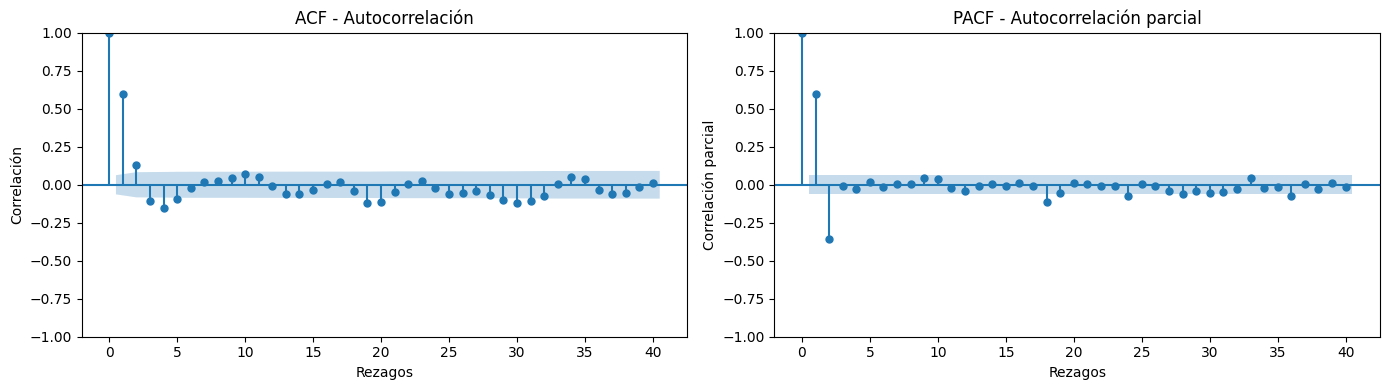

In [12]:
# usaremos la serie_estacionaria
serie_plot = serie_estacionaria

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF (para q)
plot_acf(serie_plot, lags=40, ax=axes[0])
axes[0].set_title("ACF - Autocorrelación")
axes[0].set_xlabel("Rezagos")
axes[0].set_ylabel("Correlación")

# PACF (para p)
plot_pacf(serie_plot, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF - Autocorrelación parcial")
axes[1].set_xlabel("Rezagos")
axes[1].set_ylabel("Correlación parcial")

plt.tight_layout()
plt.show()


# Modelo

In [13]:
# Vamos a usar hasta 2023 y testear en 2024
df_semanal = df_semanal.sort_index()
train = df_semanal.loc[:'2023-12-01']   # Ajusta el string según tu índice
test = df_semanal.loc['2024-01-01':'2024-12-01']

In [14]:
# Mejores hiperparametros
modelo, order, seasonal_order, resumen = buscar_hiperparametros_arima_sarima(train, m=12, seasonal=True)
print(resumen)
print("Mejores (p, d, q):", order)
print("Mejores (P, D, Q, m):", seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=422.187, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=39.826, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2.603, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=420.258, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=0.661, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2.607, Time=0.44 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2.327, Time=1.41 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-53.808, Time=0.20 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-51.954, Time=0.55 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-51.964, Time=0.69 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-51.890, Time=1.82 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=38.013, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-76.828, Time=0.27 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-75.053, Time=0.99 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=

In [15]:

# Buscar el mejor modelo ARIMA con AIC
modelo, order, resumen = buscar_hiperparametros_arima_semanal(
    serie=train,
    max_p=3, max_d=2, max_q=3,
    criterio='aic',
    trace=True
)

print(resumen)          
print("Mejores (p, d, q):", order)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=422.187, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.013, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.661, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=420.258, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53.808, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.828, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.695, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-76.817, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-74.700, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-80.663, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.024, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-78.783, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-78.794, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-55.789, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-76.667, 

In [16]:
order

(2, 1, 0)

In [17]:
seasonal_order

(0, 0, 0, 12)

## Rolling prediction

In [21]:
# --- ROLLING PREDICTION SEMANAL ---
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-30', freq='W-MON')  # Todos los lunes de 2024

for fecha in fechas_pred:
    modelo = ARIMA(serie_rolling, order=order, seasonal_order=seasonal_order)
    fitted = modelo.fit()
    pred = fitted.forecast(steps=1).iloc[0]
    predicciones.append(pred)

    # Si tienes datos reales para esa fecha, puedes usarlos aquí
    if fecha in df_semanal.index:
        valor_a_agregar = df_semanal.loc[fecha]
    else:
        valor_a_agregar = pred

    serie_rolling = pd.concat([serie_rolling, pd.Series([valor_a_agregar], index=[fecha])])


In [ ]:
# ver las 5 primeras predicciones
predicciones[:5]


[np.float64(11.314471898969513),
 np.float64(13.471763041937276),
 np.float64(13.133101248071403),
 np.float64(14.655320967393655),
 np.float64(15.303108708967427)]

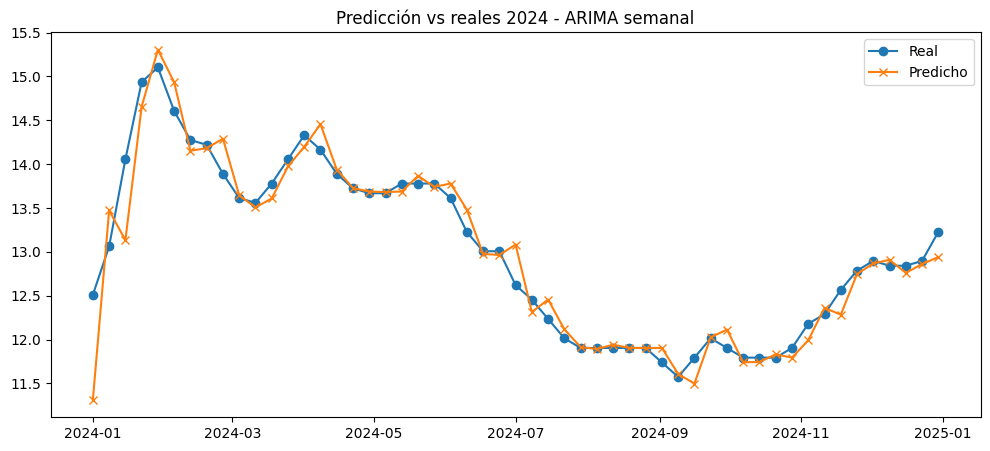

In [ ]:
reales_disponibles = [df_semanal[fecha] if fecha in df_semanal.index else None for fecha in fechas_pred]

plt.figure(figsize=(12, 5))
plt.plot(fechas_pred, reales_disponibles, label='Real', marker='o') # REAL
plt.plot(fechas_pred, predicciones, label='Predicho', marker='x')   # PREDICHO
plt.title('Predicción vs reales 2024 - ARIMA semanal')
plt.legend()
#plt.grid(True)
plt.show()


## Guardar log y predicciones

In [ ]:
# --- GUARDAR LOG Y PREDICCIONES ---
horizonte = len(fechas_pred) # 53 semanas predichas
date = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
dir_checkpoint = f"""results/ARIMA_{order[0]}_{order[1]}_{order[2]}_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}_{date}/"""

os.makedirs(dir_checkpoint, exist_ok=True)

logDict = {
    "p": order[0], "d": order[1], "q": order[2],
    "P": seasonal_order[0], "D": seasonal_order[1],
    "Q": seasonal_order[2], "M": seasonal_order[3],
    "Horizonte": horizonte,
    "Rolling": "Semanal 2024"
}

with open(os.path.join(dir_checkpoint, 'log.json'), 'w') as f:
    json.dump(logDict, f, indent=4)

# Guardar CSV de predicciones
pred_df = pd.DataFrame({'fecha': fechas_pred, 'predicho': predicciones})
pred_df.to_csv(os.path.join(dir_checkpoint, 'predicciones.csv'), index=False)

print(f"Predicciones y log guardados en: {dir_checkpoint}")


Predicciones y log guardados en: results/ARIMA_2_1_0_0_0_0_12_2025-06-12_10-30-47/


## Métricas

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- FUNCIÓN PARA MÉTRICAS CON STD ---
def calcular_metricas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    errores = y_true - y_pred
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((errores) / y_true)) * 100

    return {
        'MSE': [mse], 'MSE_STD': [np.std(errores ** 2)],
        'MAE': [mae], 'MAE_STD': [np.std(np.abs(errores))],
        'RMSE': [rmse], 'RMSE_STD': [np.std(np.sqrt(errores ** 2))],
        'MAPE': [mape], 'MAPE_STD': [np.std(np.abs((errores / y_true) * 100))]
    }

# --- CALCULAR Y GUARDAR MÉTRICAS ---
reales = [df_semanal[fecha] for fecha in fechas_pred if fecha in df_semanal.index]
predichos = pred_df['predicho'][:len(reales)]

metricas = calcular_metricas(reales, predichos)
metricas_df = pd.DataFrame.from_dict(metricas)

# Guardar CSV de métricas
metricas_df.to_csv(os.path.join(dir_checkpoint, 'metricas.csv'), index=False)

print(f"Métricas guardadas en: {dir_checkpoint}")


Métricas guardadas en: results/ARIMA_2_1_0_0_0_0_12_2025-06-12_10-30-47/
